In [1]:
from itertools import product
import numpy as np
import random
import math
import time
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
import networkx as nx
import colorsys
import imageio
import tsplib95
from tqdm import tqdm

In [2]:
class Firefly():

    def __init__(self, node_num, solution=None):
        self.node_num = node_num
        if solution is None:
            self.solution = np.random.permutation(node_num)
        else:
            self.solution = solution

        self.arcs = {(self.solution[i], self.solution[i+1]) for i in range(-1, len(self.solution)-1)}
    
    def __str__(self):
        path = ""
        for s in self.solution:
            path += f"{s} -> "
        path = path + f"{self.solution[0]}"
        return path

    def move(self, step_size=2):
        mutate_solution = self.solution.copy()
        if step_size <= 2:
            invert_size = 2
        else:
            invert_size = np.random.randint(2, step_size)
        invert_index_start = random.randint(0, self.node_num-invert_size)
        invert_index_end = invert_index_start + invert_size - 1
        mutate_solution[invert_index_start:invert_index_end+1] = mutate_solution[invert_index_start:invert_index_end+1][::-1]
        return Firefly(self.node_num, mutate_solution)

In [3]:
class FireflyAlgorithm():
    def __init__(self, tspPath='../tsp_graph/berlin52.tsp', firefly_total=5, firefly_child_total=10):
        #Load graph
        self.problem = tsplib95.load(tspPath)
        self.node_num = len(list(self.problem.get_nodes()))
        self.coords = [self.problem.node_coords[i] for i in list(self.problem.get_nodes())]
        self.dist_mat = np.zeros(shape=(self.node_num, self.node_num))
        for i, j in product(range(self.node_num), range(self.node_num)):
            self.dist_mat[i][j] = self.problem.get_weight(i+1, j+1)
            
        self.firefly_total = firefly_total
        self.firefly_child_total = firefly_child_total
        self.fireflies = np.array([Firefly(self.node_num) for _ in range(self.firefly_total)])
        self.fireflies_history = [self.fireflies]
        self.cost_history = []

        

    def fireflyDistance(self, firefly1, firefly2):
        """
        Calculate the distance between two firefly by counting the total number of different arcs
        """
        path1 = firefly1.arcs
        path2 = firefly2.arcs
        return len(path1.difference(path2))

    def attractiveness(self, firefly1, firefly2):
        distance = self.fireflyDistance(firefly1, firefly2) / self.node_num * 10
        beta0 = 1
        gamma = 1
        return beta0 * np.exp(-gamma * distance ** 2)

    def mostAttractiveFirefly(self, fireflyIndex):
        """
        return the index of firefly that is most attractive to the input firefly
        """
        mostAttractiveIndex = 0
        mostAttractiveScore = 0
        for otherFireflyIndex in range(self.firefly_total):
            if otherFireflyIndex != fireflyIndex:
                if self.attractiveness(self.fireflies[fireflyIndex], self.fireflies[otherFireflyIndex]) > mostAttractiveScore:
                    mostAttractiveIndex = otherFireflyIndex
                    mostAttractiveScore = self.attractiveness(self.fireflies[fireflyIndex], self.fireflies[otherFireflyIndex])
        return mostAttractiveIndex

    def selectBestFireflies(self):
        """
        Only keep the fireflies that have the smallest cost
        """
        costs = np.array([self.total_cost(firefly) for firefly in self.fireflies])
        bestFireflyIndex = np.argpartition(costs, self.firefly_total-1)[:self.firefly_total]
#         print(bestFireflyIndex)
#         print(f"costs: {costs[bestFireflyIndex]}")
        self.fireflies = np.array(self.fireflies)[bestFireflyIndex]
        # Record the history
        self.fireflies_history.append(self.fireflies)
        self.cost_history.append(np.min(costs))

    def bestSolution(self):
        costs = np.array([self.total_cost(firefly) for firefly in self.fireflies])
        bestFireflyIndex = np.argmin(costs)
        return self.fireflies[bestFireflyIndex].solution
    
    def getBestFireflyIndex(self):
        costs = np.array([self.total_cost(firefly) for firefly in self.fireflies])
        return np.argmin(costs)

    def find_solution(self, iteration=1):
        for i in tqdm(range(iteration)):
            # For each firefly, find the most attractive firefly
            for fireflyIndex in range(self.firefly_total):
                firefly = self.fireflies[fireflyIndex]
                mostAttractiveFireflyIndex = self.mostAttractiveFirefly(fireflyIndex)
                if mostAttractiveFireflyIndex == fireflyIndex:
                    continue
                mostAttractiveFirefly = self.fireflies[self.mostAttractiveFirefly(fireflyIndex)]

                distance = self.fireflyDistance(firefly, mostAttractiveFirefly)
                # Mutate #firefly_child_total times
                curr_firefly = firefly
                for j in range(self.firefly_child_total):
                    firefly_child = curr_firefly.move(int(distance))
                    self.fireflies = np.append(self.fireflies, firefly_child)
                    curr_firefly = firefly_child

            bestFireflyIndex = self.getBestFireflyIndex()
            bestFirefly = self.fireflies[bestFireflyIndex]
            self.fireflies = self.fireflies[self.firefly_total:]
            self.fireflies = np.append(self.fireflies, bestFirefly)

            # Find the best n fireflies
            self.selectBestFireflies()
            
            # Debug console
#             costs = np.array([self.total_cost(firefly) for firefly in self.fireflies])
#             print(f"Cost {i} {np.min(costs)}")


    def total_cost(self, firefly):
        solution = firefly.solution
        if len(solution) < 2:
            return 0  # there is no travel

        total_cost = 0
        for i in range(len(solution) - 1):
            total_cost += self.dist_mat[solution[i], solution[i+1]].item()

        # if this solution is "complete", go back to initial point
        if len(solution) == self.dist_mat.shape[0]:
            total_cost += self.dist_mat[solution[-1], solution[0]].item()

        return total_cost

    def render(self, onlyGraph=False):
        self.cords_x = []
        self.cords_y = []
        for i in self.problem.get_nodes():
            self.cords_x.append(self.problem.as_name_dict()['node_coords'][i][0])
            self.cords_y.append(self.problem.as_name_dict()['node_coords'][i][1])
        plt.clf()
        solution = self.bestSolution().tolist()
        graph = plt.plot(self.cords_x, self.cords_y, 'ro')
        plt.title(f"{self.problem.name}, Current Cost: {self.cost_history[-1]}")
        for i in range(-1, len(solution) - 1):
            plt.plot([self.cords_x[solution[i]], self.cords_x[solution[i+1]]], [self.cords_y[solution[i]], self.cords_y[solution[i+1]]], 'g-', lw=1)
        plt.show()
        
#         num_nodes = len(self.coords)
#         labels = {(i, j): round(self.dist_mat[i][j], 2) for i in range(num_nodes) for j in range(num_nodes)}

#         G = nx.from_numpy_array(np.array(self.dist_mat), create_using=nx.DiGraph())
#         pos = {i: self.coords[i] for i in range(num_nodes)}
#         plt.figure(figsize=(6, 6))
#         nx.draw_networkx(G, pos, arrows=False, with_labels=True, node_size=500, node_color='lightblue',edge_color='#CCCCCC', font_size=8)

#         if not onlyGraph:
#             solution = self.bestSolution().tolist()
#             tsp_edges = [(solution[i], solution[i+1]) for i in range(-1, len(solution)-1)]
#             other_edges = [(i, j) for i in range(num_nodes) for j in range(num_nodes) if (i, j) not in tsp_edges]
#             nx.draw_networkx_edges(G, pos, edgelist=tsp_edges, edge_color='red', width=2.0, arrows=None, arrowstyle='->')

#         plt.title(f"Travel Salesman Problem Solution\n{self.bestSolution().tolist() if not onlyGraph else ''}")
#         plt.axis("off")
#         plt.savefig(f"best_solution.png")

    def show(self, savePath='./fig'):
        for history_index in range(len(self.fireflies_history)):
            edgesOccurTimes = np.zeros((self.node_num, self.node_num))
            for f in self.fireflies_history[history_index]:
                for start, end in f.arcs:
                    edgesOccurTimes[start][end] += 1
        
            num_nodes = len(self.coords)
            labels = {(i, j): round(self.dist_mat[i][j], 2) for i in range(num_nodes) for j in range(num_nodes)}

            G = nx.from_numpy_array(np.array(self.dist_mat), create_using=nx.DiGraph())
            pos = {i: self.coords[i] for i in range(num_nodes)}

            fig = plt.figure(figsize=(6, 6))
            nx.draw_networkx(G, pos, arrows=False, with_labels=True, node_size=500, node_color='lightblue', edge_color='#CCCCCC', font_size=8)
            # nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_color='red')

            for i, j in product(range(self.node_num), range(self.node_num)):
                if edgesOccurTimes[i][j] == 0:
                    continue
                edge = [(i, j)]
                v = edgesOccurTimes[i][j] / np.max(edgesOccurTimes) * 128 + 127
                color = colorsys.hsv_to_rgb(0/255, 255/255, v/255)
                nx.draw_networkx_edges(G, pos, edgelist=edge, edge_color=color, width=2, arrows=False)


            plt.title(f"Travel Salesman Problem Solution {history_index}")
            plt.axis("off")
            # plt.show()
            plt.savefig(f"{savePath}/{history_index}.png")
            plt.close(fig)

        # Create gif
        frames = []
        for history_index in range(len(self.fireflies_history)):
            image = imageio.v2.imread(f'{savePath}/{history_index}.png')
            frames.append(image)
        imageio.mimsave(f'{savePath}/history.gif', # output gif
                frames,          # array of input frames
                fps = 5)


In [4]:
FA = FireflyAlgorithm(tspPath='../tsp_graph/berlin52.tsp',firefly_total=15, firefly_child_total=10)

In [64]:
FA.firefly_child_total=10
FA.find_solution(iteration=2000)


100%|███████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:34<00:00, 57.34it/s]


[3014.0, 3014.0, 3014.0, 3014.0, 3014.0, 3014.0, 3014.0, 3014.0, 3014.0, 3014.0, 3014.0, 3014.0, 3014.0, 3014.0, 3014.0, 3014.0, 3014.0, 3014.0, 3014.0, 3014.0, 3014.0, 3012.0, 3012.0, 3012.0, 3012.0, 3006.0, 3006.0, 3006.0, 3006.0, 3006.0]


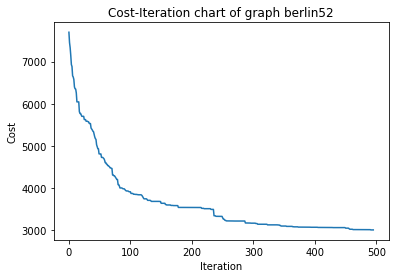

In [70]:
print(FA.cost_history[-30:])
plt.title(f"Cost-Iteration chart of graph {'berlin52'}")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.plot(FA.cost_history)

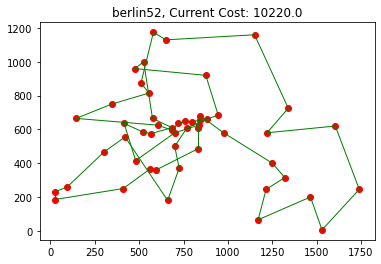

None


In [65]:
print(FA.render())

Cost 0 26356.0
Cost 1 26121.0
Cost 2 25289.0
Cost 3 24336.0
Cost 4 23481.0
Cost 5 23440.0
Cost 6 22820.0
Cost 7 22077.0
Cost 8 21361.0
Cost 9 21185.0
Cost 10 20667.0
Cost 11 20397.0
Cost 12 20022.0
Cost 13 19417.0
Cost 14 19041.0
Cost 15 18795.0
Cost 16 18179.0
Cost 17 17820.0
Cost 18 17304.0
Cost 19 17156.0
Cost 20 16839.0
Cost 21 16633.0
Cost 22 16190.0
Cost 23 15918.0
Cost 24 15615.0
Cost 25 14948.0
Cost 26 14931.0
Cost 27 14587.0
Cost 28 14587.0
Cost 29 14266.0
Cost 30 14244.0
Cost 31 13927.0
Cost 32 13821.0
Cost 33 13739.0
Cost 34 13614.0
Cost 35 13433.0
Cost 36 13290.0
Cost 37 13180.0
Cost 38 13156.0
Cost 39 12819.0
Cost 40 12775.0
Cost 41 12606.0
Cost 42 12562.0
Cost 43 12501.0
Cost 44 12457.0
Cost 45 12232.0
Cost 46 12220.0
Cost 47 12079.0
Cost 48 11921.0
Cost 49 11469.0
Cost 50 11469.0
Cost 51 11469.0
Cost 52 11170.0
Cost 53 11147.0
Cost 54 11093.0
Cost 55 10918.0
Cost 56 10918.0
Cost 57 10918.0
Cost 58 10874.0
Cost 59 10747.0
Cost 60 10724.0
Cost 61 10644.0
Cost 62 10640.0
Co

Cost 26 15213.0
Cost 27 14879.0
Cost 28 14873.0
Cost 29 14243.0
Cost 30 14002.0
Cost 31 13933.0
Cost 32 13880.0
Cost 33 13603.0
Cost 34 13501.0
Cost 35 13274.0
Cost 36 13146.0
Cost 37 13049.0
Cost 38 12713.0
Cost 39 12686.0
Cost 40 12329.0
Cost 41 12180.0
Cost 42 12029.0
Cost 43 12029.0
Cost 44 11884.0
Cost 45 11806.0
Cost 46 11589.0
Cost 47 11398.0
Cost 48 11381.0
Cost 49 11284.0
Cost 50 11179.0
Cost 51 11157.0
Cost 52 11072.0
Cost 53 10955.0
Cost 54 10955.0
Cost 55 10885.0
Cost 56 10770.0
Cost 57 10770.0
Cost 58 10718.0
Cost 59 10718.0
Cost 60 10718.0
Cost 61 10718.0
Cost 62 10707.0
Cost 63 10707.0
Cost 64 10581.0
Cost 65 10536.0
Cost 66 10215.0
Cost 67 10215.0
Cost 68 10215.0
Cost 69 10204.0
Cost 70 10204.0
Cost 71 10166.0
Cost 72 10091.0
Cost 73 9831.0
Cost 74 9831.0
Cost 75 9831.0
Cost 76 9831.0
Cost 77 9810.0
Cost 78 9736.0
Cost 79 9736.0
Cost 80 9719.0
Cost 81 9665.0
Cost 82 9664.0
Cost 83 9651.0
Cost 84 9651.0
Cost 85 9651.0
Cost 86 9642.0
Cost 87 9608.0
Cost 88 9580.0
Cost 89 

Cost 62 10567.0
Cost 63 10567.0
Cost 64 10567.0
Cost 65 10567.0
Cost 66 10567.0
Cost 67 10567.0
Cost 68 10567.0
Cost 69 10567.0
Cost 70 10567.0
Cost 71 10567.0
Cost 72 10567.0
Cost 73 10567.0
Cost 74 10567.0
Cost 75 10567.0
Cost 76 10567.0
Cost 77 10567.0
Cost 78 10567.0
Cost 79 10567.0
Cost 80 10567.0
Cost 81 10567.0
Cost 82 10567.0
Cost 83 10567.0
Cost 84 10567.0
Cost 85 10567.0
Cost 86 10567.0
Cost 87 10567.0
Cost 88 10567.0
Cost 89 10567.0
Cost 90 10567.0
Cost 91 10567.0
Cost 92 10567.0
Cost 93 10567.0
Cost 94 10567.0
Cost 95 10567.0
Cost 96 10567.0
Cost 97 10567.0
Cost 98 10567.0
Cost 99 10567.0
Cost 0 27043.0
Cost 1 25729.0
Cost 2 25338.0
Cost 3 24604.0
Cost 4 22844.0
Cost 5 22419.0
Cost 6 21933.0
Cost 7 20876.0
Cost 8 20690.0
Cost 9 20162.0
Cost 10 19706.0
Cost 11 18837.0
Cost 12 18639.0
Cost 13 18068.0
Cost 14 17817.0
Cost 15 17106.0
Cost 16 16899.0
Cost 17 16474.0
Cost 18 16369.0
Cost 19 15917.0
Cost 20 15622.0
Cost 21 15406.0
Cost 22 15027.0
Cost 23 14871.0
Cost 24 14462.0
Co

Cost 90 9226.0
Cost 91 9226.0
Cost 92 9226.0
Cost 93 9226.0
Cost 94 9226.0
Cost 95 9226.0
Cost 96 9226.0
Cost 97 9226.0
Cost 98 9226.0
Cost 99 9226.0
Cost 0 25473.0
Cost 1 24838.0
Cost 2 23977.0
Cost 3 23408.0
Cost 4 23181.0
Cost 5 22384.0
Cost 6 21837.0
Cost 7 21120.0
Cost 8 20697.0
Cost 9 20084.0
Cost 10 19517.0
Cost 11 19356.0
Cost 12 18959.0
Cost 13 18274.0
Cost 14 18183.0
Cost 15 17838.0
Cost 16 17655.0
Cost 17 17308.0
Cost 18 16834.0
Cost 19 16781.0
Cost 20 16220.0
Cost 21 16106.0
Cost 22 15859.0
Cost 23 15728.0
Cost 24 15537.0
Cost 25 15060.0
Cost 26 14664.0
Cost 27 14635.0
Cost 28 14411.0
Cost 29 14122.0
Cost 30 14027.0
Cost 31 13653.0
Cost 32 13371.0
Cost 33 13340.0
Cost 34 13249.0
Cost 35 13000.0
Cost 36 12824.0
Cost 37 12824.0
Cost 38 12396.0
Cost 39 12343.0
Cost 40 12302.0
Cost 41 11906.0
Cost 42 11889.0
Cost 43 11774.0
Cost 44 11644.0
Cost 45 11302.0
Cost 46 11293.0
Cost 47 11293.0
Cost 48 11183.0
Cost 49 11100.0
Cost 50 10996.0
Cost 51 10627.0
Cost 52 10485.0
Cost 53 1043

Cost 20 15784.0
Cost 21 15784.0
Cost 22 15742.0
Cost 23 15439.0
Cost 24 15343.0
Cost 25 15014.0
Cost 26 14809.0
Cost 27 14571.0
Cost 28 14571.0
Cost 29 14486.0
Cost 30 14365.0
Cost 31 14271.0
Cost 32 13677.0
Cost 33 13677.0
Cost 34 13531.0
Cost 35 13531.0
Cost 36 13300.0
Cost 37 12798.0
Cost 38 12707.0
Cost 39 12649.0
Cost 40 12388.0
Cost 41 12366.0
Cost 42 12170.0
Cost 43 12148.0
Cost 44 11987.0
Cost 45 11892.0
Cost 46 11720.0
Cost 47 11588.0
Cost 48 11427.0
Cost 49 11281.0
Cost 50 11239.0
Cost 51 11085.0
Cost 52 10936.0
Cost 53 10936.0
Cost 54 10841.0
Cost 55 10756.0
Cost 56 10710.0
Cost 57 10691.0
Cost 58 10661.0
Cost 59 10634.0
Cost 60 10495.0
Cost 61 10465.0
Cost 62 10459.0
Cost 63 10454.0
Cost 64 10317.0
Cost 65 10309.0
Cost 66 10275.0
Cost 67 10275.0
Cost 68 10232.0
Cost 69 9957.0
Cost 70 9935.0
Cost 71 9935.0
Cost 72 9901.0
Cost 73 9901.0
Cost 74 9632.0
Cost 75 9632.0
Cost 76 9632.0
Cost 77 9603.0
Cost 78 9603.0
Cost 79 9603.0
Cost 80 9603.0
Cost 81 9603.0
Cost 82 9596.0
Cost 8

Cost 48 11222.0
Cost 49 11222.0
Cost 50 11210.0
Cost 51 11209.0
Cost 52 11085.0
Cost 53 11085.0
Cost 54 11082.0
Cost 55 10969.0
Cost 56 10842.0
Cost 57 10747.0
Cost 58 10747.0
Cost 59 10668.0
Cost 60 10456.0
Cost 61 10297.0
Cost 62 10297.0
Cost 63 10294.0
Cost 64 10219.0
Cost 65 10209.0
Cost 66 10147.0
Cost 67 10081.0
Cost 68 10081.0
Cost 69 10081.0
Cost 70 10057.0
Cost 71 10031.0
Cost 72 10028.0
Cost 73 10006.0
Cost 74 9889.0
Cost 75 9886.0
Cost 76 9886.0
Cost 77 9872.0
Cost 78 9866.0
Cost 79 9866.0
Cost 80 9866.0
Cost 81 9851.0
Cost 82 9841.0
Cost 83 9828.0
Cost 84 9799.0
Cost 85 9761.0
Cost 86 9692.0
Cost 87 9692.0
Cost 88 9692.0
Cost 89 9692.0
Cost 90 9692.0
Cost 91 9689.0
Cost 92 9660.0
Cost 93 9660.0
Cost 94 9660.0
Cost 95 9660.0
Cost 96 9660.0
Cost 97 9660.0
Cost 98 9660.0
Cost 99 9660.0
Cost 0 26617.0
Cost 1 26163.0
Cost 2 25099.0
Cost 3 24792.0
Cost 4 24188.0
Cost 5 23647.0
Cost 6 23010.0
Cost 7 22804.0
Cost 8 22421.0
Cost 9 21174.0
Cost 10 20892.0
Cost 11 20595.0
Cost 12 2003

Cost 78 9850.0
Cost 79 9801.0
Cost 80 9801.0
Cost 81 9779.0
Cost 82 9730.0
Cost 83 9730.0
Cost 84 9713.0
Cost 85 9655.0
Cost 86 9620.0
Cost 87 9620.0
Cost 88 9620.0
Cost 89 9603.0
Cost 90 9603.0
Cost 91 9603.0
Cost 92 9603.0
Cost 93 9603.0
Cost 94 9603.0
Cost 95 9603.0
Cost 96 9603.0
Cost 97 9603.0
Cost 98 9603.0
Cost 99 9603.0
Cost 0 25910.0
Cost 1 24969.0
Cost 2 24539.0
Cost 3 24027.0
Cost 4 23416.0
Cost 5 22859.0
Cost 6 22276.0
Cost 7 22041.0
Cost 8 20444.0
Cost 9 20069.0
Cost 10 19602.0
Cost 11 19146.0
Cost 12 18850.0
Cost 13 18407.0
Cost 14 18133.0
Cost 15 17730.0
Cost 16 17405.0
Cost 17 17197.0
Cost 18 16791.0
Cost 19 16617.0
Cost 20 16114.0
Cost 21 15185.0
Cost 22 15185.0
Cost 23 15106.0
Cost 24 14787.0
Cost 25 14503.0
Cost 26 14453.0
Cost 27 14188.0
Cost 28 14082.0
Cost 29 13731.0
Cost 30 13592.0
Cost 31 13436.0
Cost 32 13360.0
Cost 33 13073.0
Cost 34 13073.0
Cost 35 12849.0
Cost 36 12849.0
Cost 37 12662.0
Cost 38 12335.0
Cost 39 12335.0
Cost 40 12191.0
Cost 41 11983.0
Cost 42 

Cost 11 19566.0
Cost 12 19182.0
Cost 13 18853.0
Cost 14 18393.0
Cost 15 18105.0
Cost 16 17646.0
Cost 17 17528.0
Cost 18 17443.0
Cost 19 17084.0
Cost 20 16877.0
Cost 21 16194.0
Cost 22 16087.0
Cost 23 15699.0
Cost 24 15615.0
Cost 25 15397.0
Cost 26 15290.0
Cost 27 15030.0
Cost 28 14789.0
Cost 29 14254.0
Cost 30 14094.0
Cost 31 13781.0
Cost 32 13644.0
Cost 33 13364.0
Cost 34 12832.0
Cost 35 12753.0
Cost 36 12623.0
Cost 37 12357.0
Cost 38 12255.0
Cost 39 12184.0
Cost 40 11887.0
Cost 41 11887.0
Cost 42 11778.0
Cost 43 11753.0
Cost 44 11687.0
Cost 45 11557.0
Cost 46 11439.0
Cost 47 11394.0
Cost 48 11360.0
Cost 49 11319.0
Cost 50 11190.0
Cost 51 11046.0
Cost 52 10889.0
Cost 53 10761.0
Cost 54 10605.0
Cost 55 10481.0
Cost 56 10466.0
Cost 57 10466.0
Cost 58 10466.0
Cost 59 10361.0
Cost 60 10168.0
Cost 61 10128.0
Cost 62 10128.0
Cost 63 9934.0
Cost 64 9914.0
Cost 65 9893.0
Cost 66 9850.0
Cost 67 9758.0
Cost 68 9668.0
Cost 69 9668.0
Cost 70 9666.0
Cost 71 9641.0
Cost 72 9641.0
Cost 73 9617.0
Cos

Cost 43 11736.0
Cost 44 11496.0
Cost 45 11496.0
Cost 46 11336.0
Cost 47 11278.0
Cost 48 11278.0
Cost 49 11258.0
Cost 50 11192.0
Cost 51 11141.0
Cost 52 11138.0
Cost 53 11138.0
Cost 54 11026.0
Cost 55 11026.0
Cost 56 11013.0
Cost 57 10859.0
Cost 58 10842.0
Cost 59 10842.0
Cost 60 10842.0
Cost 61 10842.0
Cost 62 10842.0
Cost 63 10762.0
Cost 64 10716.0
Cost 65 10692.0
Cost 66 10459.0
Cost 67 10206.0
Cost 68 10206.0
Cost 69 10206.0
Cost 70 10183.0
Cost 71 10183.0
Cost 72 10183.0
Cost 73 10129.0
Cost 74 10050.0
Cost 75 9984.0
Cost 76 9984.0
Cost 77 9964.0
Cost 78 9964.0
Cost 79 9964.0
Cost 80 9953.0
Cost 81 9953.0
Cost 82 9953.0
Cost 83 9953.0
Cost 84 9953.0
Cost 85 9953.0
Cost 86 9953.0
Cost 87 9953.0
Cost 88 9953.0
Cost 89 9953.0
Cost 90 9953.0
Cost 91 9953.0
Cost 92 9953.0
Cost 93 9953.0
Cost 94 9953.0
Cost 95 9953.0
Cost 96 9953.0
Cost 97 9953.0
Cost 98 9953.0
Cost 99 9953.0
Cost 0 24919.0
Cost 1 24622.0
Cost 2 24050.0
Cost 3 23317.0
Cost 4 23000.0
Cost 5 22569.0
Cost 6 21983.0
Cost 7 2

Cost 71 9694.0
Cost 72 9694.0
Cost 73 9661.0
Cost 74 9593.0
Cost 75 9448.0
Cost 76 9416.0
Cost 77 9416.0
Cost 78 9416.0
Cost 79 9377.0
Cost 80 9365.0
Cost 81 9289.0
Cost 82 9259.0
Cost 83 9165.0
Cost 84 9165.0
Cost 85 9128.0
Cost 86 9128.0
Cost 87 9122.0
Cost 88 8844.0
Cost 89 8828.0
Cost 90 8820.0
Cost 91 8820.0
Cost 92 8708.0
Cost 93 8682.0
Cost 94 8682.0
Cost 95 8678.0
Cost 96 8665.0
Cost 97 8665.0
Cost 98 8663.0
Cost 99 8656.0
Cost 0 26547.0
Cost 1 26263.0
Cost 2 25076.0
Cost 3 24231.0
Cost 4 23265.0
Cost 5 22741.0
Cost 6 21791.0
Cost 7 21320.0
Cost 8 20795.0
Cost 9 20362.0
Cost 10 19897.0
Cost 11 19231.0
Cost 12 19072.0
Cost 13 18784.0
Cost 14 18114.0
Cost 15 17562.0
Cost 16 16946.0
Cost 17 16426.0
Cost 18 16387.0
Cost 19 15909.0
Cost 20 15791.0
Cost 21 15686.0
Cost 22 15218.0
Cost 23 15142.0
Cost 24 15088.0
Cost 25 14421.0
Cost 26 14417.0
Cost 27 14210.0
Cost 28 13941.0
Cost 29 13940.0
Cost 30 13722.0
Cost 31 13499.0
Cost 32 13430.0
Cost 33 13430.0
Cost 34 13226.0
Cost 35 13066.0

Cost 0 24931.0
Cost 1 24651.0
Cost 2 23455.0
Cost 3 22564.0
Cost 4 22204.0
Cost 5 21669.0
Cost 6 20472.0
Cost 7 20389.0
Cost 8 20165.0
Cost 9 19245.0
Cost 10 18573.0
Cost 11 18096.0
Cost 12 17185.0
Cost 13 17166.0
Cost 14 16752.0
Cost 15 16380.0
Cost 16 15282.0
Cost 17 15282.0
Cost 18 14950.0
Cost 19 14667.0
Cost 20 14594.0
Cost 21 14151.0
Cost 22 13690.0
Cost 23 13661.0
Cost 24 13273.0
Cost 25 13135.0
Cost 26 13135.0
Cost 27 12735.0
Cost 28 12727.0
Cost 29 12277.0
Cost 30 12277.0
Cost 31 11876.0
Cost 32 11876.0
Cost 33 11652.0
Cost 34 11560.0
Cost 35 11468.0
Cost 36 11369.0
Cost 37 11369.0
Cost 38 11358.0
Cost 39 11300.0
Cost 40 11113.0
Cost 41 11048.0
Cost 42 10906.0
Cost 43 10881.0
Cost 44 10821.0
Cost 45 10590.0
Cost 46 10590.0
Cost 47 10576.0
Cost 48 10440.0
Cost 49 10440.0
Cost 50 10440.0
Cost 51 10367.0
Cost 52 10273.0
Cost 53 10269.0
Cost 54 10224.0
Cost 55 10224.0
Cost 56 10223.0
Cost 57 10126.0
Cost 58 9973.0
Cost 59 9941.0
Cost 60 9826.0
Cost 61 9826.0
Cost 62 9815.0
Cost 63

Cost 30 13376.0
Cost 31 13376.0
Cost 32 13034.0
Cost 33 13001.0
Cost 34 12932.0
Cost 35 12866.0
Cost 36 12806.0
Cost 37 12666.0
Cost 38 12565.0
Cost 39 12421.0
Cost 40 12277.0
Cost 41 12231.0
Cost 42 12184.0
Cost 43 11901.0
Cost 44 11872.0
Cost 45 11855.0
Cost 46 11669.0
Cost 47 11608.0
Cost 48 11335.0
Cost 49 11277.0
Cost 50 11233.0
Cost 51 11001.0
Cost 52 10797.0
Cost 53 10782.0
Cost 54 10720.0
Cost 55 10623.0
Cost 56 10608.0
Cost 57 10432.0
Cost 58 10263.0
Cost 59 10219.0
Cost 60 10115.0
Cost 61 10115.0
Cost 62 10050.0
Cost 63 9933.0
Cost 64 9616.0
Cost 65 9616.0
Cost 66 9616.0
Cost 67 9601.0
Cost 68 9601.0
Cost 69 9512.0
Cost 70 9429.0
Cost 71 9387.0
Cost 72 9337.0
Cost 73 9337.0
Cost 74 9337.0
Cost 75 9337.0
Cost 76 9295.0
Cost 77 9282.0
Cost 78 9282.0
Cost 79 9282.0
Cost 80 9275.0
Cost 81 9240.0
Cost 82 9240.0
Cost 83 9240.0
Cost 84 9103.0
Cost 85 9103.0
Cost 86 9067.0
Cost 87 9067.0
Cost 88 9067.0
Cost 89 9067.0
Cost 90 9067.0
Cost 91 9051.0
Cost 92 9050.0
Cost 93 9050.0
Cost 94

Cost 70 10480.0
Cost 71 10479.0
Cost 72 10465.0
Cost 73 10465.0
Cost 74 10465.0
Cost 75 10436.0
Cost 76 10436.0
Cost 77 10425.0
Cost 78 10425.0
Cost 79 10425.0
Cost 80 10425.0
Cost 81 10422.0
Cost 82 10422.0
Cost 83 10414.0
Cost 84 10414.0
Cost 85 10414.0
Cost 86 10414.0
Cost 87 10414.0
Cost 88 10410.0
Cost 89 10410.0
Cost 90 10410.0
Cost 91 10410.0
Cost 92 10410.0
Cost 93 10410.0
Cost 94 10410.0
Cost 95 10410.0
Cost 96 10410.0
Cost 97 10410.0
Cost 98 10410.0
Cost 99 10410.0
Cost 0 27248.0
Cost 1 26782.0
Cost 2 24653.0
Cost 3 24450.0
Cost 4 23689.0
Cost 5 23436.0
Cost 6 22675.0
Cost 7 22266.0
Cost 8 21752.0
Cost 9 21452.0
Cost 10 21297.0
Cost 11 20317.0
Cost 12 19972.0
Cost 13 19094.0
Cost 14 18702.0
Cost 15 18191.0
Cost 16 18019.0
Cost 17 17635.0
Cost 18 17082.0
Cost 19 16558.0
Cost 20 16535.0
Cost 21 16059.0
Cost 22 15843.0
Cost 23 15386.0
Cost 24 15284.0
Cost 25 15280.0
Cost 26 15148.0
Cost 27 14980.0
Cost 28 14787.0
Cost 29 14717.0
Cost 30 14489.0
Cost 31 14270.0
Cost 32 13941.0
Co

Cost 98 8829.0
Cost 99 8829.0
Cost 0 27249.0
Cost 1 26714.0
Cost 2 25991.0
Cost 3 25600.0
Cost 4 25198.0
Cost 5 23591.0
Cost 6 23142.0
Cost 7 22591.0
Cost 8 22149.0
Cost 9 21322.0
Cost 10 21305.0
Cost 11 20415.0
Cost 12 19549.0
Cost 13 18700.0
Cost 14 18428.0
Cost 15 18171.0
Cost 16 17753.0
Cost 17 17611.0
Cost 18 17260.0
Cost 19 17059.0
Cost 20 16684.0
Cost 21 16506.0
Cost 22 15907.0
Cost 23 15876.0
Cost 24 15708.0
Cost 25 15398.0
Cost 26 15311.0
Cost 27 15027.0
Cost 28 14851.0
Cost 29 14632.0
Cost 30 14383.0
Cost 31 13881.0
Cost 32 13826.0
Cost 33 13198.0
Cost 34 12930.0
Cost 35 12673.0
Cost 36 12609.0
Cost 37 12515.0
Cost 38 11933.0
Cost 39 11933.0
Cost 40 11623.0
Cost 41 11527.0
Cost 42 11254.0
Cost 43 11045.0
Cost 44 11045.0
Cost 45 10931.0
Cost 46 10838.0
Cost 47 10739.0
Cost 48 10661.0
Cost 49 10557.0
Cost 50 10423.0
Cost 51 10217.0
Cost 52 10217.0
Cost 53 10217.0
Cost 54 10102.0
Cost 55 10102.0
Cost 56 10074.0
Cost 57 9984.0
Cost 58 9984.0
Cost 59 9970.0
Cost 60 9954.0
Cost 61 

Cost 23 15678.0
Cost 24 15224.0
Cost 25 14865.0
Cost 26 14418.0
Cost 27 14101.0
Cost 28 14101.0
Cost 29 13854.0
Cost 30 13854.0
Cost 31 13651.0
Cost 32 13373.0
Cost 33 13330.0
Cost 34 13162.0
Cost 35 12694.0
Cost 36 12619.0
Cost 37 12239.0
Cost 38 12239.0
Cost 39 12207.0
Cost 40 12207.0
Cost 41 12043.0
Cost 42 11931.0
Cost 43 11792.0
Cost 44 11725.0
Cost 45 11483.0
Cost 46 11195.0
Cost 47 11167.0
Cost 48 11167.0
Cost 49 11065.0
Cost 50 10987.0
Cost 51 10933.0
Cost 52 10698.0
Cost 53 10698.0
Cost 54 10629.0
Cost 55 10629.0
Cost 56 10628.0
Cost 57 10588.0
Cost 58 10323.0
Cost 59 10323.0
Cost 60 10217.0
Cost 61 10148.0
Cost 62 10148.0
Cost 63 10126.0
Cost 64 9928.0
Cost 65 9904.0
Cost 66 9904.0
Cost 67 9799.0
Cost 68 9751.0
Cost 69 9685.0
Cost 70 9685.0
Cost 71 9625.0
Cost 72 9554.0
Cost 73 9519.0
Cost 74 9491.0
Cost 75 9397.0
Cost 76 9329.0
Cost 77 9329.0
Cost 78 9315.0
Cost 79 9315.0
Cost 80 9270.0
Cost 81 9256.0
Cost 82 9256.0
Cost 83 9255.0
Cost 84 9221.0
Cost 85 9200.0
Cost 86 9200.0

Cost 59 10460.0
Cost 60 10460.0
Cost 61 10344.0
Cost 62 10262.0
Cost 63 10237.0
Cost 64 10051.0
Cost 65 10051.0
Cost 66 9935.0
Cost 67 9935.0
Cost 68 9912.0
Cost 69 9912.0
Cost 70 9799.0
Cost 71 9799.0
Cost 72 9799.0
Cost 73 9762.0
Cost 74 9739.0
Cost 75 9732.0
Cost 76 9732.0
Cost 77 9172.0
Cost 78 9172.0
Cost 79 9172.0
Cost 80 9172.0
Cost 81 9172.0
Cost 82 9172.0
Cost 83 9172.0
Cost 84 9172.0
Cost 85 9123.0
Cost 86 9115.0
Cost 87 9115.0
Cost 88 9096.0
Cost 89 9096.0
Cost 90 9071.0
Cost 91 9049.0
Cost 92 9049.0
Cost 93 9047.0
Cost 94 9025.0
Cost 95 8981.0
Cost 96 8981.0
Cost 97 8947.0
Cost 98 8944.0
Cost 99 8897.0
Cost 0 27581.0
Cost 1 26126.0
Cost 2 25265.0
Cost 3 24581.0
Cost 4 24095.0
Cost 5 23468.0
Cost 6 22617.0
Cost 7 22325.0
Cost 8 21838.0
Cost 9 21134.0
Cost 10 20469.0
Cost 11 19832.0
Cost 12 19325.0
Cost 13 18605.0
Cost 14 18605.0
Cost 15 18279.0
Cost 16 17914.0
Cost 17 17604.0
Cost 18 17097.0
Cost 19 16932.0
Cost 20 16521.0
Cost 21 15926.0
Cost 22 15884.0
Cost 23 15579.0
Cost

Cost 92 9268.0
Cost 93 9268.0
Cost 94 9268.0
Cost 95 9268.0
Cost 96 9268.0
Cost 97 9268.0
Cost 98 9268.0
Cost 99 9268.0
Cost 0 25723.0
Cost 1 24806.0
Cost 2 23767.0
Cost 3 22989.0
Cost 4 22515.0
Cost 5 22160.0
Cost 6 21872.0
Cost 7 21366.0
Cost 8 20368.0
Cost 9 19984.0
Cost 10 19722.0
Cost 11 19172.0
Cost 12 18860.0
Cost 13 18544.0
Cost 14 18319.0
Cost 15 17919.0
Cost 16 17718.0
Cost 17 17428.0
Cost 18 17238.0
Cost 19 17115.0
Cost 20 16451.0
Cost 21 16291.0
Cost 22 15778.0
Cost 23 15645.0
Cost 24 14789.0
Cost 25 14789.0
Cost 26 14786.0
Cost 27 14520.0
Cost 28 14301.0
Cost 29 13817.0
Cost 30 13711.0
Cost 31 13484.0
Cost 32 13362.0
Cost 33 12937.0
Cost 34 12672.0
Cost 35 12303.0
Cost 36 12246.0
Cost 37 11879.0
Cost 38 11773.0
Cost 39 11689.0
Cost 40 11660.0
Cost 41 11496.0
Cost 42 11496.0
Cost 43 11412.0
Cost 44 11211.0
Cost 45 11142.0
Cost 46 11142.0
Cost 47 11063.0
Cost 48 11035.0
Cost 49 10975.0
Cost 50 10975.0
Cost 51 10826.0
Cost 52 10819.0
Cost 53 10798.0
Cost 54 10756.0
Cost 55 10

Cost 37 12010.0
Cost 38 11987.0
Cost 39 11987.0
Cost 40 11761.0
Cost 41 11613.0
Cost 42 11411.0
Cost 43 11154.0
Cost 44 11154.0
Cost 45 11115.0
Cost 46 11015.0
Cost 47 11015.0
Cost 48 10455.0
Cost 49 10441.0
Cost 50 10441.0
Cost 51 10067.0
Cost 52 10004.0
Cost 53 10004.0
Cost 54 9985.0
Cost 55 9985.0
Cost 56 9985.0
Cost 57 9965.0
Cost 58 9965.0
Cost 59 9964.0
Cost 60 9951.0
Cost 61 9950.0
Cost 62 9922.0
Cost 63 9922.0
Cost 64 9922.0
Cost 65 9922.0
Cost 66 9922.0
Cost 67 9920.0
Cost 68 9920.0
Cost 69 9869.0
Cost 70 9869.0
Cost 71 9866.0
Cost 72 9852.0
Cost 73 9776.0
Cost 74 9643.0
Cost 75 9643.0
Cost 76 9354.0
Cost 77 9354.0
Cost 78 9230.0
Cost 79 9212.0
Cost 80 9110.0
Cost 81 9105.0
Cost 82 9105.0
Cost 83 9088.0
Cost 84 9050.0
Cost 85 9007.0
Cost 86 8986.0
Cost 87 8958.0
Cost 88 8935.0
Cost 89 8935.0
Cost 90 8934.0
Cost 91 8931.0
Cost 92 8891.0
Cost 93 8853.0
Cost 94 8755.0
Cost 95 8750.0
Cost 96 8673.0
Cost 97 8673.0
Cost 98 8673.0
Cost 99 8634.0
Cost 0 26068.0
Cost 1 25702.0
Cost 2 2

Cost 71 9958.0
Cost 72 9958.0
Cost 73 9892.0
Cost 74 9762.0
Cost 75 9762.0
Cost 76 9753.0
Cost 77 9724.0
Cost 78 9510.0
Cost 79 9510.0
Cost 80 9481.0
Cost 81 9481.0
Cost 82 9481.0
Cost 83 9481.0
Cost 84 9480.0
Cost 85 9480.0
Cost 86 9479.0
Cost 87 9457.0
Cost 88 9208.0
Cost 89 9207.0
Cost 90 9181.0
Cost 91 9181.0
Cost 92 9166.0
Cost 93 9166.0
Cost 94 9140.0
Cost 95 9093.0
Cost 96 9086.0
Cost 97 8952.0
Cost 98 8944.0
Cost 99 8944.0
Cost 0 26939.0
Cost 1 26341.0
Cost 2 24876.0
Cost 3 24211.0
Cost 4 23852.0
Cost 5 23075.0
Cost 6 22470.0
Cost 7 21827.0
Cost 8 21406.0
Cost 9 20883.0
Cost 10 20150.0
Cost 11 19877.0
Cost 12 19563.0
Cost 13 19017.0
Cost 14 18496.0
Cost 15 18126.0
Cost 16 17912.0
Cost 17 17683.0
Cost 18 17239.0
Cost 19 17020.0
Cost 20 16693.0
Cost 21 16345.0
Cost 22 15814.0
Cost 23 15814.0
Cost 24 15630.0
Cost 25 15368.0
Cost 26 15150.0
Cost 27 15096.0
Cost 28 14800.0
Cost 29 13965.0
Cost 30 13568.0
Cost 31 13417.0
Cost 32 13334.0
Cost 33 13185.0
Cost 34 13087.0
Cost 35 12936.0

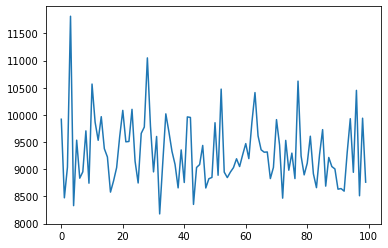

In [96]:
all_costs = []
for i in range(100):
    FA = FireflyAlgorithm(firefly_total=10, firefly_child_total=10)
    FA.find_solution(iteration=100)
    all_costs.append(FA.cost_history[-1])
plt.plot(all_costs)

In [10]:
tsp_problems = [
    "berlin52",
    "rat99",
    "bier127",
    "ch130",
    "a280"
]
import time

for tsp in tsp_problems:
    costs = []
    start_time = time.time()
    for i in range(5):
        FA = FireflyAlgorithm(tspPath=f"../tsp_graph/{tsp}.tsp",firefly_total=10, firefly_child_total=10)
        FA.find_solution(iteration=2000)
        costs.append(FA.cost_history[-1])
#         print(FA.render())
#         plt.clf()
#         plt.title(f"Cost-Iteration chart of graph {tsp}")
#         plt.xlabel("Iteration")
#         plt.ylabel("Cost")
#         plt.plot(FA.cost_history)
#         plt.show()
    end_time = time.time()
    print(f"Problem: {tsp}")
    print(f"Mean: {np.mean(costs)}")
    print(f"Std: {np.std(costs)}")
    print(f"Avg time: {(end_time-start_time)/5}")
    print(f"Min: {np.min(costs)}")
    print(f"Max: {np.max(costs)}")
    
#     print(f"{tsp}: {FA.cost_history[-1]}")
    

100%|███████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:16<00:00, 26.15it/s]


Problem: rat99
Mean: 2915.6
Std: 278.4360608829251
Avg time: 59.71895327568054
Min: 2604.0
Max: 3440.0


100%|███████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:21<00:00, 24.63it/s]


Problem: bier127
Mean: 272727.6
Std: 8591.661646037977
Avg time: 85.98232316970825
Min: 261526.0
Max: 286210.0


100%|███████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:20<00:00, 24.87it/s]


Problem: ch130
Mean: 18001.8
Std: 847.4968790503007
Avg time: 68.8089289188385
Min: 16940.0
Max: 19055.0


100%|███████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:20<00:00, 14.21it/s]

Problem: a280
Mean: 12791.4
Std: 366.47051723160484
Avg time: 134.7054003238678
Min: 12189.0
Max: 13320.0
